# MTS ШАД NN text

## Libs

In [ ]:
# ! pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model

from datasets import Dataset as Dataset_hf
from datasets import DatasetDict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-08-19 05:53:29.576348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 05:53:29.576482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 05:53:29.871338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data

In [ ]:
df_train = pd.read_csv('/kaggle/input/nn-text/train.csv')
df_test = pd.read_csv('/kaggle/input/nn-text/test.csv')

In [ ]:
df_train['Rating'] = df_train['Rating'].apply(lambda x: 0 if x==999 else x)

### Text preprocessing

In [ ]:
from nltk.stem.porter import PorterStemmer

In [ ]:
stop_words = set(stopwords.words('english'))
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stemmer = PorterStemmer()

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(text_cleaning_re, ' ', text).strip()
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [ ]:
df_train['text_prepared'] = df_train['Review'].apply(lambda x: preprocess_text(x))

In [ ]:
X = np.array(df_train['text_prepared'])
X_roberta = np.array(df_train['Review'])
y = np.array(df_train['Rating'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2)

X_roberta_train, X_roberta_test, y_roberta_train, y_roberta_test = train_test_split(X_roberta, y,
                                                    stratify=y,
                                                    test_size=0.2)

print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 11474
Test Data size 2869


### Prepare for submission

In [ ]:
df_test['text_prepared'] = df_test['Review'].apply(lambda x: preprocess_text(x))

In [ ]:
test_data = np.array(df_test['text_prepared'])

In [ ]:
test_data_roberta = np.array(df_test['Review'])

In [ ]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader_test):
            inputs = inputs.to(device)
            outputs = model(inputs, torch.sum(inputs != PAD_IDX, dim=1).cpu()).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_to_submission(model, name, dataloader_test, is_torch=True):
    if is_torch:
        probs = predict(model, dataloader_test)
        preds = np.argmax(probs, axis=1)
    else:
        preds = model.predict(dataloader_test)
    submission = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')
    submission['Rating'] = preds
    submission.to_csv('./'+name+'.csv', index=False)

## Modeling

### LogReg with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_text_tfidf = vectorizer_tfidf.transform(X_test)

In [ ]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model_tfidf.predict(X_text_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6117113976995469
Confusion Matrix:
 [[   0    0    0    0    0    1]
 [   0  132   40    6    5   16]
 [   0   38   84   35   58   36]
 [   0   11   25   56  158   56]
 [   0    3   10   23  430  379]
 [   0    0    2    5  207 1053]]


In [ ]:
predict_to_submission(model_tfidf, 'log_reg_and_tfidf', vectorizer_tfidf.transform(test_data), is_torch=False)

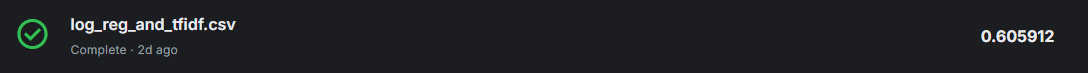

### LSTM

In [ ]:
from collections import Counter

In [ ]:
class MyTokenizer():
    def __init__(self, max_words):
        self.max_words = max_words

    def fit(self, texts):
        words = Counter()
        for text in texts:
            for word in text.split():
                words[word] += 1
        top_words = sorted(words.items(), key=lambda item: item[1], reverse=True)[:self.max_words]

        self.vocab = {word[0]: i+1 for i, word in enumerate(top_words)}
        self.vocab['<PAD>'] = 0
        self.vocab['<UNK>'] = self.max_words+1
        self.decode_vocab = {v: k for k, v in self.vocab.items()}

    def token_to_id(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else:
            return self.vocab['<UNK>']

    def encode(self, text):
        arr = []
        for word in text.split():
            if word in self.vocab:
                arr.append(self.vocab[word])
            else:
                arr.append(self.vocab['<UNK>'])
        return arr

    def decode(self, sequence):
        arr = []
        for token in sequence:
            if token in self.decode_vocab:
                arr.append(self.decode_vocab[token])
            else:
                arr.append('<UNK>')
        return ' '.join(arr)


In [ ]:
tokenizer = MyTokenizer(8000)

In [ ]:
tokenizer.fit(X_train)

In [ ]:
X_train[3]

'fluentli brighten nice quiet vacat return week long stay excel overal nice imho vacat immedi say return nice laid think saw book read vacat travel 2 time year 25 year opinion aspect resort faciliit clean maintain restaur good good food wait 10 minut group 8 split 2 group eat french restaur use tabl prepar spend 2 hour dinner realli time bring cours pool nice especi larg pool day lot debri float pool pretti nasti reason skim pool previou night cascad pool desert week peopl sit read book bar conveni locat resort good varieti alcohol includ bud bud light mgd cours president actual good tequila drinker like better varieti cuervo premium tequila best show resort show quit entertain wast time go noth even good fun night outroom larg comfort power issu virtual day power daili inconveni day wash dinner resort probabl 1 2 capac stay includ 30 40 peopl new york came srping break come distract'

In [ ]:
tokenizer.decode(tokenizer.encode('sharaton flightw 5 star servic hotel wow vacat new york palac amaz let tell servic servic amaz right need help maid nicer nice desk gave rate reason servic superb let tell room stay 36 floor overlook cathedr saint patrick die room neat cleaner bed confort unlik bed slept room servic door give ask minut mayb second beyound spectacular room permiss rest eat breakfast lunch dinner appet desert exectut loung worth abl eat loung overlook cathedr beyound luxuri room execut loung spa excersic room amaz took nice refresh sauna shower robe slipper 18 older use excercis room work tv hook tredmeel equip enjoy nice movi moment watch movi tv abl overlook cathedr better view room execut loung well that got say hotel worth went new york citi 2 time trip stay trump tower plaza 5 star servic hotel oranienburg'))

'<UNK> <UNK> 5 star servic hotel wow vacat new york palac amaz let tell servic servic amaz right need help maid nicer nice desk gave rate reason servic superb let tell room stay 36 floor overlook cathedr saint patrick die room neat cleaner bed confort unlik bed slept room servic door give ask minut mayb second <UNK> spectacular room permiss rest eat breakfast lunch dinner appet desert <UNK> loung worth abl eat loung overlook cathedr <UNK> luxuri room execut loung spa <UNK> room amaz took nice refresh sauna shower robe slipper 18 older use excercis room work tv hook <UNK> equip enjoy nice movi moment watch movi tv abl overlook cathedr better view room execut loung well that got say hotel worth went new york citi 2 time trip stay trump tower plaza 5 star servic hotel <UNK>'

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=150):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_text = self.tokenizer.encode(text)
        if len(encoded_text) > self.max_len:
            encoded_text = encoded_text[:self.max_len]
        else:
            encoded_text += [self.tokenizer.token_to_id("<PAD>")] * (self.max_len - len(encoded_text))
        return torch.tensor(encoded_text), torch.tensor(label)

In [ ]:
train_dataset = TextDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TextDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = hidden[-1,:,:]
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(tokenizer.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 6
N_LAYERS = 2
PAD_IDX = tokenizer.token_to_id("<pad>")

model_lstm = TextLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, PAD_IDX)

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader):
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts, torch.sum(texts != PAD_IDX, dim=1).cpu())
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts, torch.sum(texts != PAD_IDX, dim=1).cpu())
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            predicted = torch.argmax(predictions.squeeze(1), -1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return epoch_loss / len(dataloader), correct / total

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

In [ ]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model_lstm, train_dataloader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}')

    test_loss, test_accuracy = evaluate_model(model_lstm, test_dataloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

100%|██████████| 718/718 [00:16<00:00, 43.80it/s]


Epoch 1/5, Training Loss: 1.1821


100%|██████████| 180/180 [00:01<00:00, 101.36it/s]


Test Loss: 1.0935, Test Accuracy: 0.5539


100%|██████████| 718/718 [00:16<00:00, 42.89it/s]


Epoch 2/5, Training Loss: 1.0285


100%|██████████| 180/180 [00:01<00:00, 100.96it/s]


Test Loss: 0.9677, Test Accuracy: 0.5845


100%|██████████| 718/718 [00:16<00:00, 43.00it/s]


Epoch 3/5, Training Loss: 0.8582


100%|██████████| 180/180 [00:01<00:00, 102.24it/s]


Test Loss: 0.9525, Test Accuracy: 0.5932


100%|██████████| 718/718 [00:16<00:00, 43.92it/s]


Epoch 4/5, Training Loss: 0.7223


100%|██████████| 180/180 [00:01<00:00, 103.85it/s]


Test Loss: 0.9919, Test Accuracy: 0.5716


100%|██████████| 718/718 [00:16<00:00, 43.43it/s]


Epoch 5/5, Training Loss: 0.5764


100%|██████████| 180/180 [00:01<00:00, 103.83it/s]

Test Loss: 1.1008, Test Accuracy: 0.5985


In [ ]:
submission_data = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')

In [ ]:
dataset_test = TextDataset(test_data, np.array(submission_data['Rating']), tokenizer)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [ ]:
predict_to_submission(model_lstm, 'simple_lstm', dataloader_test)

100%|██████████| 385/385 [00:03<00:00, 102.26it/s]


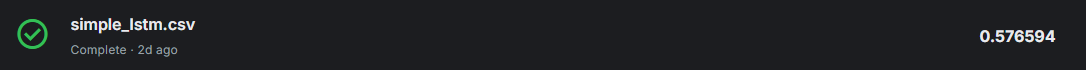

### RoBerta

In [ ]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
model_name = 'roberta-base'

id2label = {i: label for i, label in enumerate(list(range(6)))}

roberta_tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_name, id2label=id2label)

data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer, return_tensors="pt")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    run_name='mts-roberta-r_48',
    output_dir='mts-roberta-model-r_48',
    learning_rate=1e-3,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=250,
    save_steps=1e3,
)

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=48, lora_alpha=16, lora_dropout=0.1)
peft_model = get_peft_model(roberta_model, peft_config)

print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 2,364,678 || all params: 127,014,924 || trainable%: 1.8617


In [ ]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleD

In [ ]:
df_test

,index,Review,text_prepared
0,0,"saefood bubbas want iwant ro riu wow, riu bamb...",saefood bubba want iwant ro riu wow riu bambu ...
1,1,raging she__ç_éö enjoyably different just retu...,rage enjoy differ return 4 night stay comment ...
2,2,"boading terrifying best vacation, husband went...",boad terrifi best vacat husband went excel pun...
3,3,blended enthusastic location location location...,blend enthusast locat locat locat 10 year stay...
4,4,peptol insulated love hk good hotel stay noise...,peptol insul love hk good hotel stay nois x ma...
...,...,...,...
6143,6143,particapated activce loved antiche figure husb...,particap activc love antich figur husband stay...
6144,6144,ubiquitous osmond blissfull stay tegal sari ju...,ubiquit osmond blissful stay tegal sari like s...
6145,6145,rican feeder nice hotel trip seattle wanted st...,rican feeder nice hotel trip seattl want stay ...
6146,6146,maintanace disembark basic good value chose ho...,maintanac disembark basic good valu chose hote...


In [ ]:
dataset_d = {
    'test': Dataset_hf.from_dict({'text': test_data_roberta, 'label': np.array(submission_data['Rating'])}),
    'train': Dataset_hf.from_dict({'text': X_roberta_train, 'label': y_roberta_train}),
    'validation': Dataset_hf.from_dict({'text': X_roberta_test, 'label': y_roberta_test})
}

dataset = DatasetDict(dataset_d)

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = roberta_tokenizer(example_batch['text'], truncation=True, padding=True)

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask']
    }

In [ ]:
tokenized_dataset = dataset.map(convert_examples_to_features, batched=True, batch_size=16, remove_columns=["text"])

Map:   0%|          | 0/6148 [00:00<?, ? examples/s]

Map:   0%|          | 0/11474 [00:00<?, ? examples/s]

Map:   0%|          | 0/2869 [00:00<?, ? examples/s]

In [ ]:
roberta_trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
)

In [ ]:
roberta_trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
250,0.887800,0.782714
500,0.847500,0.740200
750,0.717100,0.809113
1000,0.665700,0.726895
1250,0.563100,0.727131


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1436, training_loss=0.7503436441873109, metrics={'train_runtime': 2076.5487, 'train_samples_per_second': 22.102, 'train_steps_per_second': 0.692, 'total_flos': 1.2409580581060608e+16, 'train_loss': 0.7503436441873109, 'epoch': 4.0})

In [ ]:
roberta_trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.7258625030517578,
 'eval_runtime': 47.8773,
 'eval_samples_per_second': 59.924,
 'eval_steps_per_second': 3.76,
 'epoch': 4.0}

In [ ]:
peft_model_name = 'roberta-base-peft-r_48'

In [ ]:
peft_model.save_pretrained(peft_model_name)

#### Test Roberta

In [ ]:
from peft import AutoPeftModelForSequenceClassification

In [ ]:
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(peft_model_name, id2label=id2label)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def evaluate_model_roberta(model):
    model.eval()
    correct = 0
    total = 0
    eval_dataloader = DataLoader(tokenized_dataset['validation'].rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            batch.to(device)
            with torch.no_grad():
                outputs = inference_model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            predictions, references = predictions, batch["labels"]
            correct += (predictions == references).sum().item()
            total += references.size(0)
    return correct / total

In [ ]:
evaluate_model_roberta(inference_model)

100%|██████████| 359/359 [01:14<00:00,  4.81it/s]


0.6890902753572673

In [ ]:
test_dataloader = DataLoader(tokenized_dataset['test'].rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)

In [ ]:
def predict(model, dataloader_test):
    preds = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader_test):
            batch.to(device)
            with torch.no_grad():
                outputs = inference_model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            preds.extend(predictions.tolist())
    return preds

def predict_to_submission(model, name, dataloader_test, is_torch=True):
    if is_torch:
        preds = predict(model, dataloader_test)
    else:
        preds = model.predict(dataloader_test)
    submission = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')
    submission['Rating'] = preds
    submission.to_csv('./'+name+'.csv', index=False)

In [ ]:
predict_to_submission(inference_model, 'roberta_lora_r_48', test_dataloader)

100%|██████████| 769/769 [02:31<00:00,  5.07it/s]


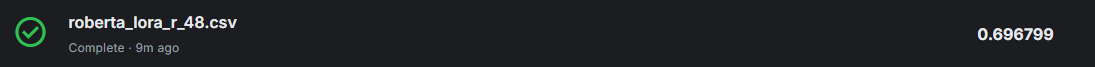